In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

from cil.io import TXRMDataReader, TIFFWriter, TIFFStackReader
from cil.processors import TransmissionAbsorptionConverter, CentreOfRotationCorrector, Slicer, Padder, RingRemover
from cil.plugins.astra import FBP
from cil.utilities.display import show2D, show_geometry
from cil.framework import AcquisitionGeometry, ImageGeometry

# Import algorithms, operators and functions from CIL optimisation module
from cil.optimisation.algorithms import CGLS, GD, FISTA, PDHG
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, \
                                       GradientOperator, FiniteDifferenceOperator
from cil.optimisation.functions import IndicatorBox, MixedL21Norm, L2NormSquared, \
                                       BlockFunction, L1Norm, LeastSquares, \
                                       OperatorCompositionFunction, TotalVariation, \
                                       ZeroFunction

# Import from CIL ASTRA plugin
from cil.plugins.astra.processors import FBP, AstraBackProjector3D
from cil.plugins.astra.operators import ProjectionOperator

In [3]:
# Define cone geometry variables
SOD = 355 # mm
SDD = 398 # mm
COR = -100 # number of pixels from the edge of the center
pixel_size = 0.048 # mm??
image_pixel_size = 0.096 # mm

angles_arr = np.linspace(0, 2*np.pi, 200)

In [4]:
# create AcquisitionGeometry
ag = AcquisitionGeometry.create_Cone3D(
    source_position=[0.0, -SOD, 0.0],
    detector_position=[COR*pixel_size, SDD-SOD, 0.0],
    rotation_axis_position=[0, 0*pixel_size, 0.0],
    rotation_axis_direction=[0., 0., 1.0]
)
ag.set_angles(angles=angles_arr, angle_unit='radian' )
ag.set_panel(num_pixels=[500, 500], pixel_size=pixel_size, origin='top-left') 

In [5]:
base_dir = os.path.abspath("Apple_offset/raw/projections/")
data = TIFFStackReader(file_name=base_dir).read_as_AcquisitionData(ag)


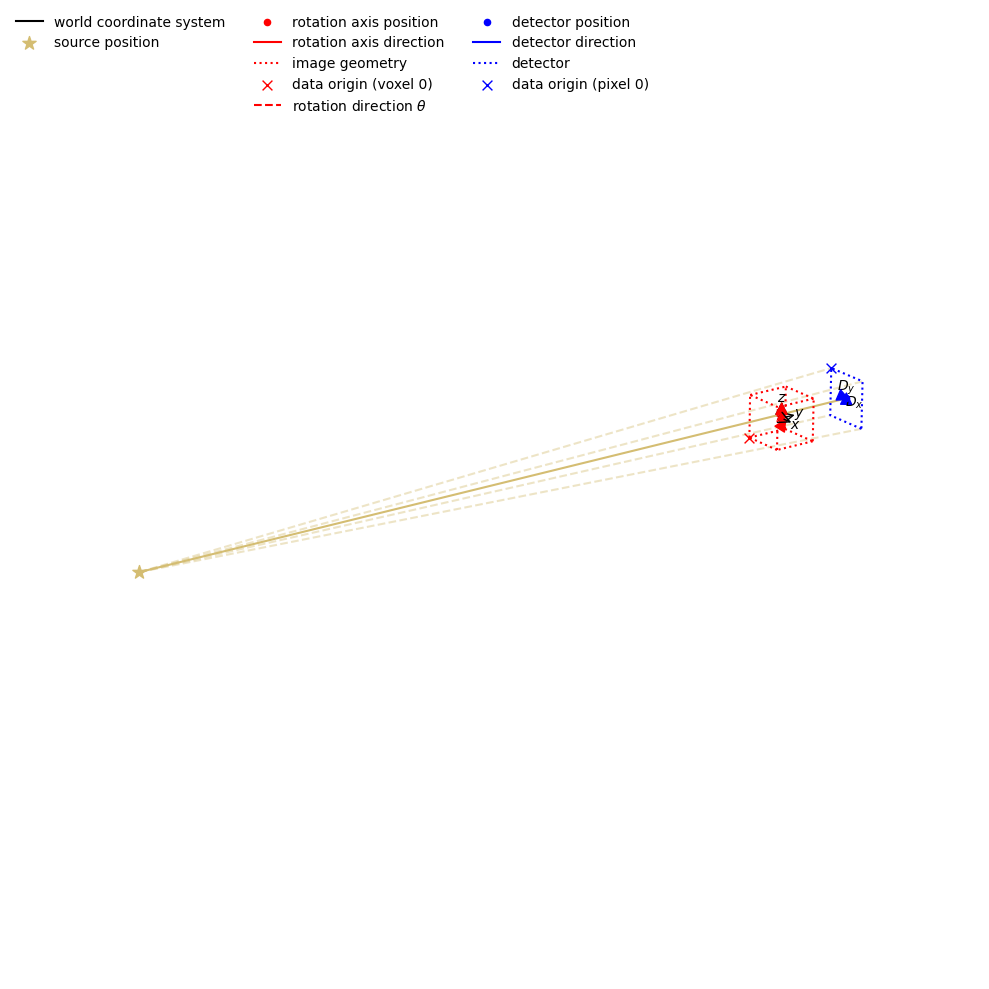

In [6]:
show_geometry(data.geometry)


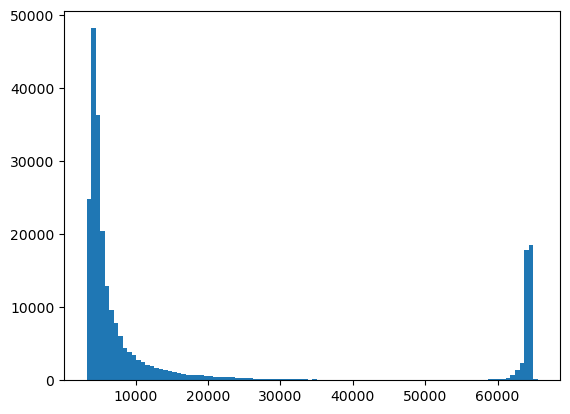

In [7]:
# Print histogram of values

#print(data.geometry)
#print(data.array)
data_Arr = data.array[0, :, :] # Define variable containing n'th projection of the apple 
data_Arr.shape

plt.figure()
plt.hist(data_Arr.flatten(), bins=100);

In [8]:
# Normalise each projection with the highest value in that projection

for i in range(200):
    data.array[i] = data.array[i]/np.max(data.array[i])

#show2D(data, slice_list=('angle',100))

In [9]:
data = TransmissionAbsorptionConverter()(data)

In [10]:
# Padding the data to remove region of interest artifact
Pad = True
if Pad:
    Npad = 300
    data = Padder(pad_width=Npad, mode='edge')(data) # Padding in both x and y

#show2D(data, slice_list=('vertical', 100)) # Plot sinogram
#show2D(data, slice_list=['angle', 50]) # Plot 50th projection

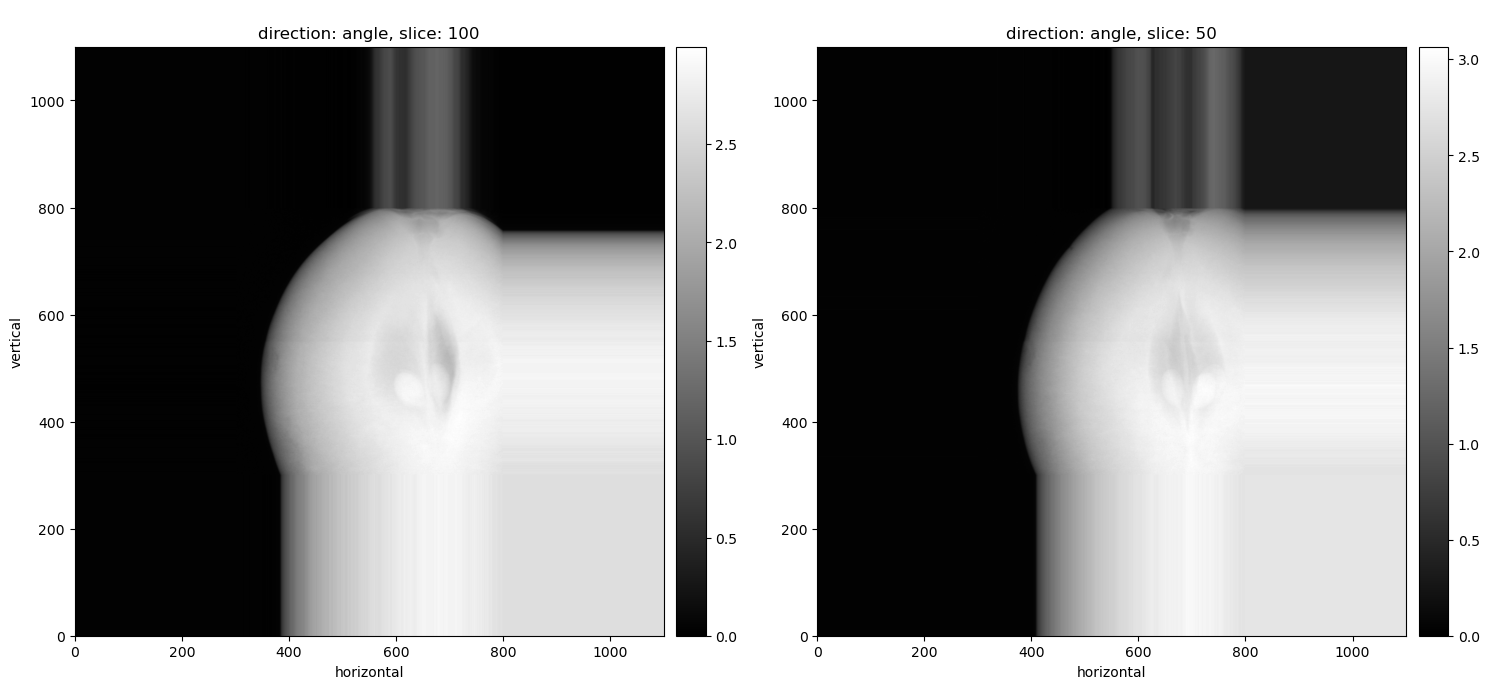

In [11]:
show2D(data, slice_list=['angle', 50]) # Plot 50th projection

In [12]:
# Remove ring artifact from sinogram
#cropped_sinogram = Slicer(roi={'vertical': (0, 500)})(data)
#b = RingRemover(decNum=4, wname='db25', sigma=15)(cropped_sinogram)

#show2D(data, slice_list=('vertical', 100)) # Plot sinogram

In [13]:
data.reorder(order='astra') # Change the order of the variables in the array
if Pad:
    ig = ImageGeometry(700, 700, 700, pixel_size, pixel_size, pixel_size)
else:
    ig = data.geometry.get_ImageGeometry() # save image geometry


## FPB reconstruction

In [14]:
fbp =  FBP(ig, data.geometry, "gpu")
recon = fbp(data)

In [15]:
# Save projections as tiff files

save_base_path = os.getcwd()
data_folder = "apple_offset_FBP_pad/"
data_name = "apple_offset_FBP_pad"
save_path = os.path.join(save_base_path, data_name)
os.makedirs(save_path)

TIFFWriter(data=recon, file_name=os.path.join(save_path, data_folder)).write()

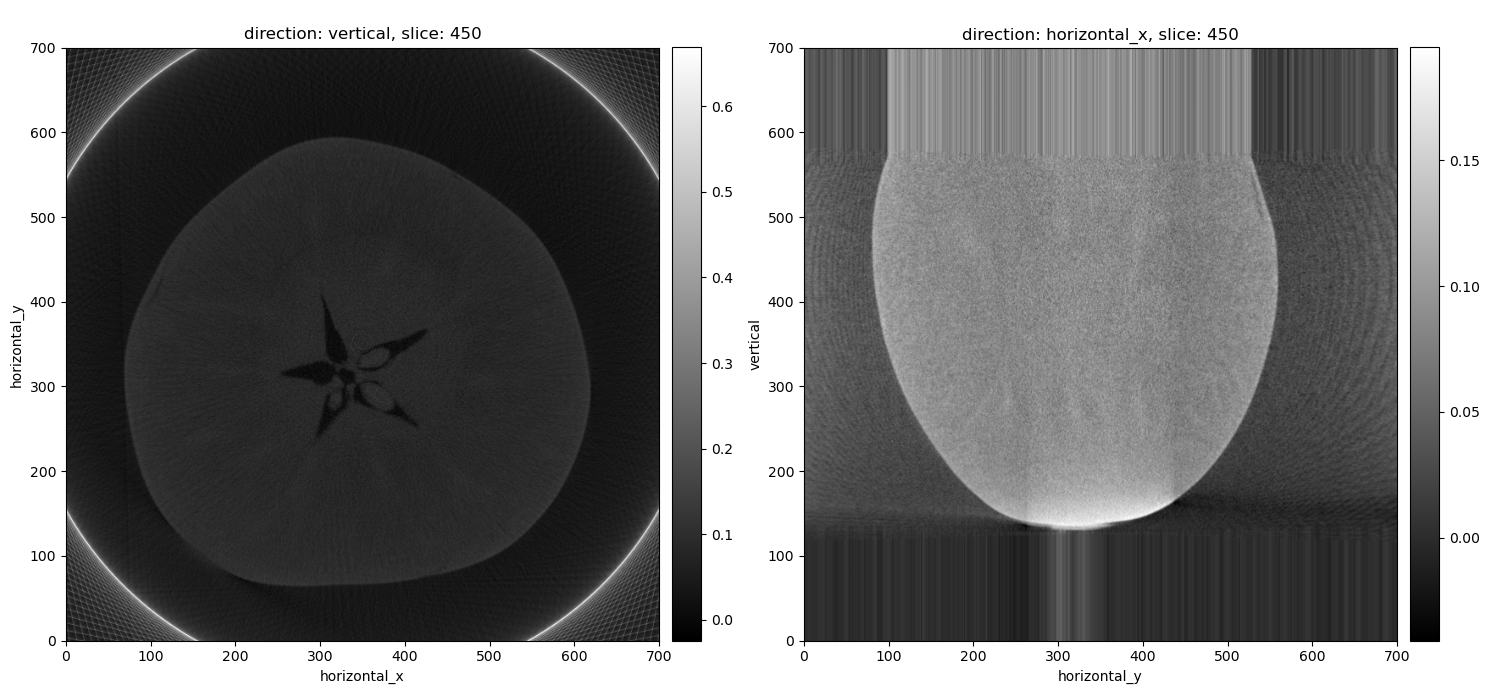

In [16]:
N_slice = 150 +Npad
show2D(recon, slice_list=[('vertical',N_slice), ('horizontal_x', N_slice)])

## Gradient descent reconstruction

In [17]:
data.reorder(order='astra') # Change the order of the variables in the array
ag = data.geometry
#ig = data.geometry.get_ImageGeometry() # save image geometry
ig = ImageGeometry(700, 700, 700, pixel_size, pixel_size, pixel_size)
b = data # Give it new name, so we have the same notation as the equations in Jacob's slides

# Set up linear operator representing forward and backward projections
A = ProjectionOperator(ig, ag, device="gpu")

In [18]:
#print(ig)

In [19]:
f1 = LeastSquares(A, b) # Set up least squares problem

x0 = ig.allocate(0.0) # Start from image no. 0
print(x0)

# Set up gradient descent algorithm
myGD_LS = GD(initial=x0, 
             objective_function=f1, 
             step_size=None, 
             max_iteration=1000, 
             update_objective_interval=1)

Number of dimensions: 3
Shape: (700, 700, 700)
Axis labels: ('vertical', 'horizontal_y', 'horizontal_x')



In [20]:
myGD_LS.run(10, verbose=1) # run gradient descent algorithm

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          7.00431e+08
        1       1000       145.237          2.67866e+08
        2       1000        79.506          2.30031e+08
        3       1000        57.572          2.24150e+08
        4       1000        46.615          2.22080e+08
        5       1000        40.043          2.20706e+08
        6       1000        35.647          2.19694e+08
        7       1000        32.509          2.18896e+08
        8       1000        30.154          2.18235e+08
        9       1000        28.334          2.17678e+08
       10       1000        26.881          2.17203e+08
-------------------------------------------------------
       10       1000        26.881          2.17203e+08
Stop criterion has been reached.



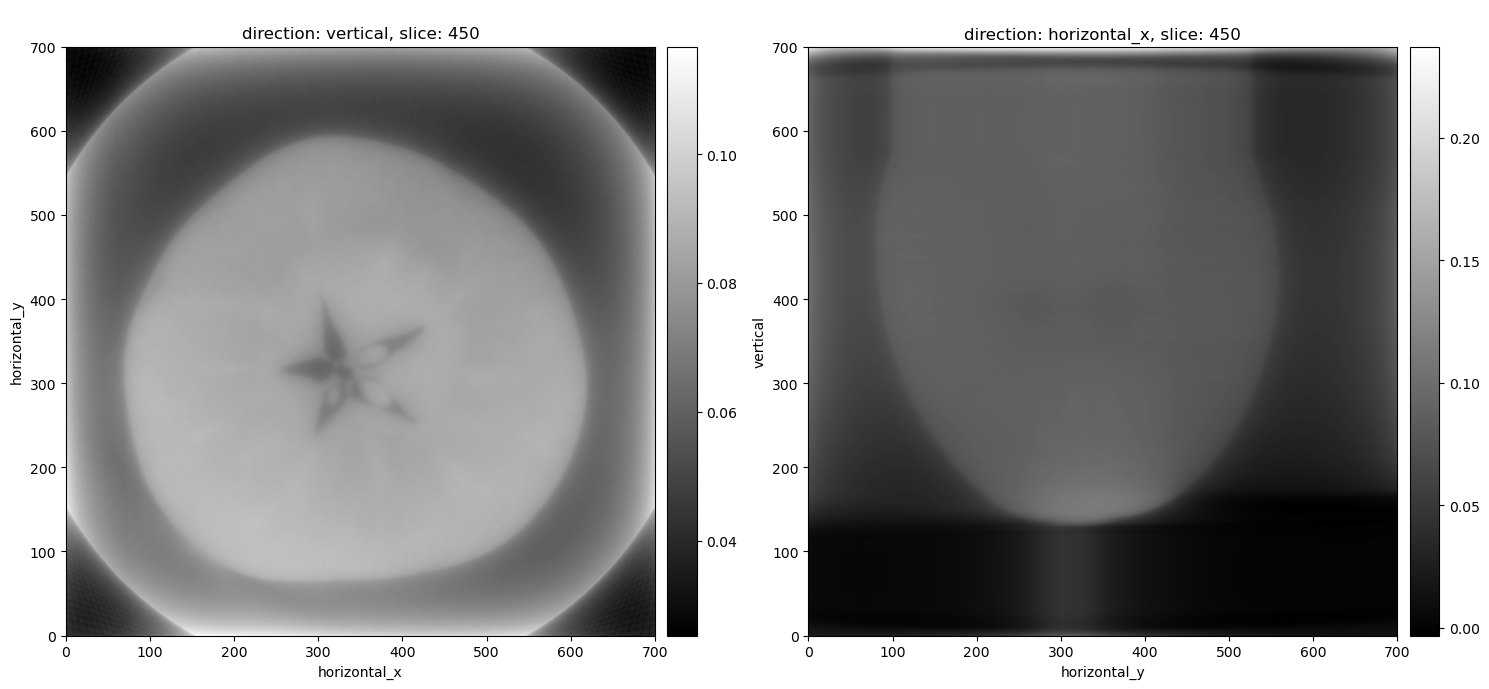

In [21]:
N_slice = 450 #+Npad
show2D(myGD_LS.solution, slice_list=[('vertical',N_slice), ('horizontal_x', N_slice)])

In [22]:
myGD_LS.run(20, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10       1000        26.881          2.17203e+08


       11       1000        25.678          2.16794e+08
       12       1000        24.680          2.16442e+08
       13       1000        23.833          2.16139e+08
       14       1000        23.111          2.15875e+08
       15       1000        22.486          2.15640e+08
       16       1000        21.935          2.15427e+08
       17       1000        21.456          2.15237e+08
       18       1000        21.025          2.15062e+08
       19       1000        20.642          2.14899e+08
       20       1000        20.294          2.14747e+08
       21       1000        19.980          2.14607e+08
       22       1000        19.695          2.14476e+08
       23       1000        19.439          2.14351e+08
       24       1000        19.202          2.14234e+08
       25       1000        18.981          2.14126e+08
       26       1000        18.781          2.14026e+08
       27       1000        18.593          2.13932e+08
       28       1000        18.453          2.13

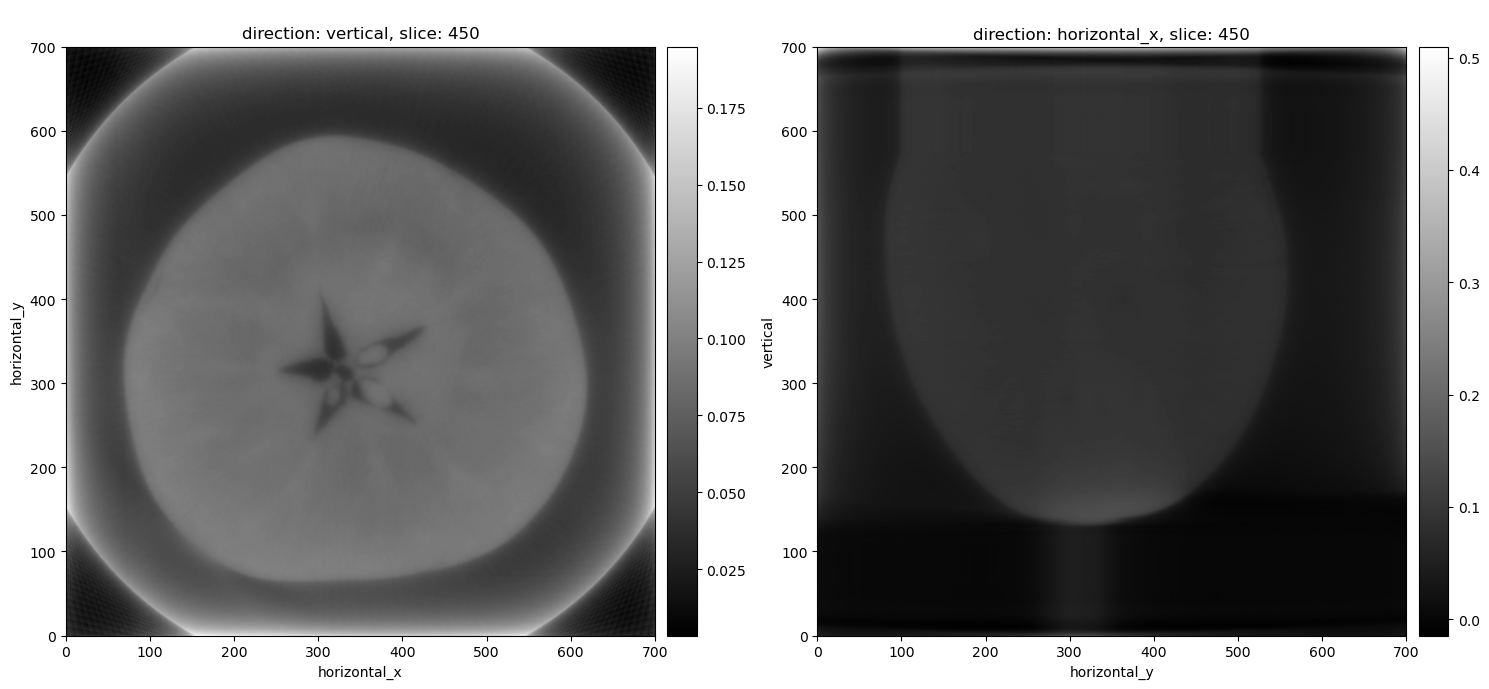

In [23]:
show2D(myGD_LS.solution, slice_list=[('vertical',N_slice), ('horizontal_x', N_slice)])

## FISTA algorithm Total Variation regularization

In [24]:
# save sinogram
b = data.get_slice(vertical='centre')
#show2D(b) # Plot sinogram

ag = b.geometry
ig = b.geometry.get_ImageGeometry() # save image geometry

#ig = ImageGeometry(700, 700, 700, pixel_size, pixel_size, pixel_size)
#b = data # Give it new name, so we have the same notation as the equations in Jacob's slides

# Set up linear operator representing forward and backward projections
#A = ProjectionOperator(ig, b.geometry, device="gpu")

In [25]:
ig.voxel_num_x=700
ig.voxel_num_y=700
x0 = ig.allocate(0.0)
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x700,y700
voxel_size : x0.04281407035175879,y0.04281407035175879
center : x0,y0



In [26]:
A = ProjectionOperator(ig, b.geometry, device="gpu")

In [27]:
f1 = LeastSquares(A, b)
GTV = 0.02*TotalVariation() # Regularization parameter is too big
myFISTATV = FISTA(
    f=f1,
    g=GTV,
    x_init=x0,
    max_iteration=100,
    update_objective_internal=2
)

TypeError: FISTA.__init__() missing 1 required positional argument: 'initial'

In [ ]:
myFISTATV.run(100, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
       10        100         0.772          1.15540e+03
       11        100         0.778          9.26862e+02
       12        100         0.779          7.68483e+02
       13        100         0.778          6.58118e+02
       14        100         0.779          5.81417e+02
       15        100         0.781          5.28066e+02
       16        100         0.781          4.90376e+02
       17        100         0.780          4.62419e+02
       18        100         0.784          4.40244e+02
       19        100         0.785          4.21531e+02
       20        100         0.786          4.05395e+02
       21        100         0.786          3.91506e+02
       22        100         0.786          3.79942e+02
       23        100         0.786          3.70598e+02
       24        100         0.785          3.63441e+02
       25        100         0.787          3.57

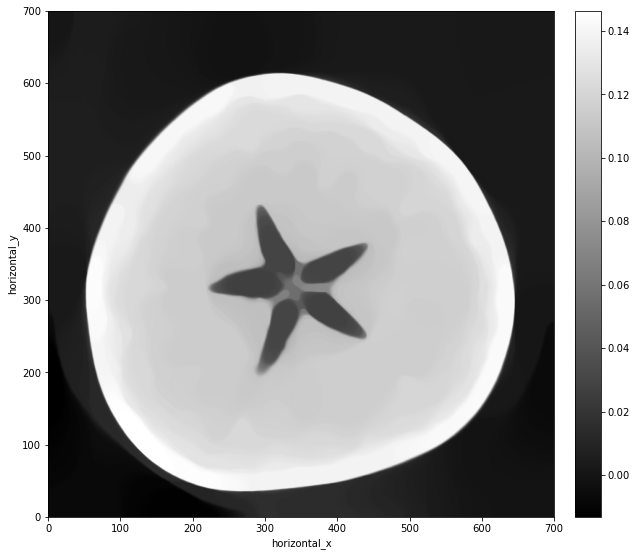

In [ ]:
show2D(myFISTATV.solution) # Smudged because of regularization parameter, might be because of the 2D as well

In [ ]:
# Change parameter of TV reconstruction
f1 = LeastSquares(A, b)
GTV = 0.002*TotalVariation() # ten times smaller than before
myFISTATV = FISTA(
    f=f1,
    g=GTV,
    x_init=x0,
    max_iteration=100,
    update_objective_internal=10
)

FISTA setting up
FISTA configured


In [ ]:
myFISTATV.run(50, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
Initialised GradientOperator with C backend running with  3  threads
        0        100         0.000          5.43498e+05
        1        100         0.905          1.66860e+04
        2        100         0.886          1.31662e+04
        3        100         0.895          9.95196e+03
        4        100         0.876          7.27946e+03
        5        100         0.874          5.20236e+03
        6        100         0.870          3.67174e+03
        7        100         0.871          2.59086e+03
        8        100         0.867          1.85046e+03
        9        100         0.865          1.35067e+03
       10        100         0.860          1.01249e+03
       11        100         0.854          7.80387e+02
       12        100         0.851          6.18633e+02
       13        100         0.849          5.05137e+02
       14        100         0.849 

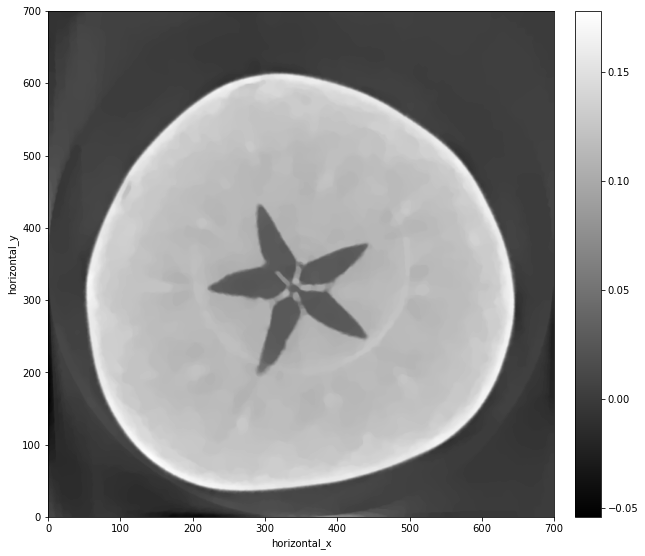

In [ ]:
show2D(myFISTATV.solution)

In [ ]:
# Change parameter of TV reconstruction

f1 = LeastSquares(A, b)
GTV = 0.0002*TotalVariation() # Hundred times smaller
myFISTATV = FISTA(
    f=f1,
    g=GTV,
    x_init=x0,
    max_iteration=100,
    update_objective_internal=10
)

FISTA setting up
FISTA configured


In [ ]:
myFISTATV.run(50, verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
Initialised GradientOperator with C backend running with  3  threads
        0        100         0.000          5.43498e+05
        1        100         0.860          1.66801e+04
        2        100         0.805          1.31588e+04
        3        100         0.789          9.94279e+03
        4        100         0.780          7.26855e+03
        5        100         0.775          5.18991e+03
        6        100         0.769          3.65800e+03
        7        100         0.762          2.57607e+03
        8        100         0.761          1.83479e+03
        9        100         0.759          1.33422e+03
       10        100         0.757          9.95299e+02
       11        100         0.754          7.62473e+02
       12        100         0.758          6.00042e+02
       13        100         0.758          4.85934e+02
       14        100         0.763 

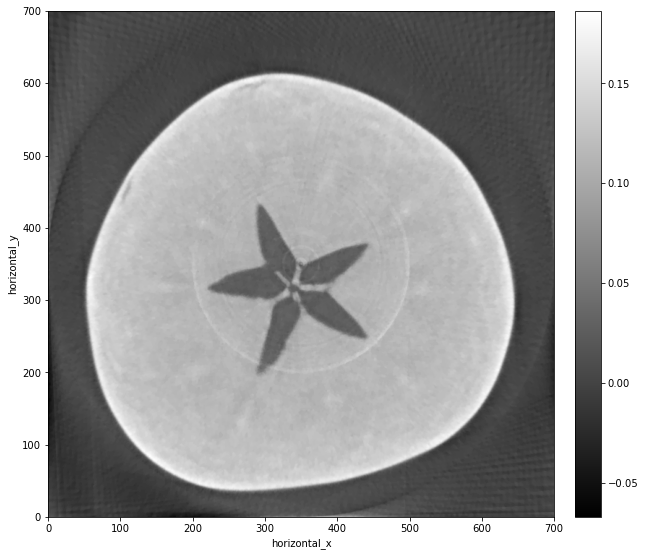

In [ ]:
show2D(myFISTATV.solution)

In [ ]:
alpha = 0.05
TV = FGP_TV(alpha=alpha, nonnegativity=True, device='gpu')
fista_TV = FISTA(initial=FDK_reco, f=LS, g=TV, max_iteration=1000, update_objective_interval=10)